In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy as scipy
from tqdm import tqdm
from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score

from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_DataProcessed.csv'")

In [3]:
#set index to unnamed
df.drop("Unnamed: 0", axis= 1, inplace= True)

In [4]:
df.head()

iphone  news  gaming  DestinyTheGame  MonsterHunter  \
0     0.0   0.0     0.0             0.0            0.0   
1     0.0   0.0     0.0             0.0            0.0   
2     0.0   0.0     0.0             0.0            0.0   
3     0.0   0.0     0.0             0.0            0.0   
4     0.0   0.0     0.0             0.0            0.0   

   single_user_subreddits  The_Donald  NoStupidQuestions  Stims  nba  ...  \
0                     0.0         0.0                0.0    0.0  0.0  ...   
1                     1.0         0.0                0.0    0.0  0.0  ...   
2                     0.0         0.0                0.0    0.0  0.0  ...   
3                     0.0         0.0                0.0    0.0  0.0  ...   
4                     1.0         0.0                0.0    0.0  0.0  ...   

   AskReddit  FortNiteBR  CircleofTrust  Showerthoughts  fo76  \
0        1.0         0.0            0.0             0.0   0.0   
1        0.0         0.0            0.0             0.0   0.0   
2        0.0         0.0            0.0             0.0   0.0   
3        0.0         0.0            0.0             0.0   0.0   
4        0.0         0.0            0.0             0.0   0.0   

   BrandNewSentence  inthesoulstone  pokemongotrades  PushaT  df_target  
0               0.0             0.0              0.0     0.0        0.0  
1               0.0             0.0              0.0     0.0        0.0  
2               0.0             0.0              0.0     0.0        0.0  
3               0.0             0.0              0.0     0.0        0.0  
4               0.0             0.0              0.0     0.0        0.0  

[5 rows x 501 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Columns: 501 entries, iphone to df_target
dtypes: float64(501)
memory usage: 305.8 MB


#### Proof of Concept modelling
* Testing models on sampled data ahead of porting to AWS for greater computational power
* Creating class function to assess various resampling methods on our data

In [3]:
# split sample into target and predictor variables
y = df.pop("df_target").to_numpy()
X = df

X
len(y)

80000

In [4]:
# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify= y, random_state=13)

# standardize data, maxabsscaler as to work on sparse data 
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
# create dataframe to track params & scoring
cols = ["phase", "model_type", "cv_score", "training_score", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [9]:
model_tracker

Empty DataFrame
Columns: [phase, model_type, cv_score, training_score, precision, recall, f1-score, TP, FP, TN, FN]
Index: []

In [10]:
#create function to run different models
def model_run(model):
    """returns average score, training score, class report metrics and confusion matrix outputs"""
    scores = cross_val_score(model, X_train, y_train, cv=5)
    # get cross val score
    scores = cross_val_score(model, X_train, y_train, cv=5)

    # get training score
    model.fit(X_train, y_train)
    training_score = model.score(X_train, y_train)

    # predict and get classification report & confusion matrix info
    predictions = model.predict(X_test)
    class_report = classification_report(y_test, predictions, output_dict= True)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    
    print("Model run complete")
    return scores, training_score, class_report, tn, fp, fn, tp

In [11]:
# logistic regression, base model
model = LogisticRegression(class_weight= "balanced", solver = "sag", max_iter= 8000)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

# append to model tracker
results = pd.Series(["PoC", "log_reg", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [12]:
# KNN, base model
model = KNeighborsClassifier()

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "KNN", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [13]:
# Decision tree, base model
model = DecisionTreeClassifier(min_samples_split= 50)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "D_Tree", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [14]:
# Random forest, basic model
model = RandomForestClassifier(n_estimators= 100, n_jobs= 2)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "Rand_Fr", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [15]:
# Gradient boost, basic model
model = model = GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1)

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "Grad_Bst", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

Model run complete


In [20]:
# Linear SVC, basic model
model = LinearSVC()

scores, training_score, class_report, tn, fp, fn, tp = model_run(model)

results = pd.Series(["PoC", "SVC", scores.mean(), training_score, class_report["1.0"]["precision"], class_report["1.0"]["recall"], class_report["1.0"]["f1-score"],tp, fp, tn, fn], index= model_tracker.columns)
model_tracker = model_tracker.append(results, ignore_index= True)

/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/samholt/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to c

Model run complete


In [21]:
model_tracker

phase model_type  cv_score  training_score  precision    recall  f1-score  \
0   PoC    log_reg  0.859857        0.866929   0.198923  0.551453  0.292378   
1   PoC        KNN  0.945982        0.951446   0.420382  0.051846  0.092308   
2   PoC     D_Tree  0.936821        0.969321   0.313869  0.168892  0.219612   
3   PoC    Rand_Fr  0.949250        0.999000   0.665094  0.110762  0.189899   
4   PoC   Grad_Bst  0.948286        0.951268   0.606299  0.060487  0.110000   
5   PoC        SVC  0.945929        0.946982   0.476658  0.152396  0.230952   

    TP    FP     TN    FN  
0  702  2827  19900   571  
1   66    91  22636  1207  
2  215   470  22257  1058  
3  141    71  22656  1132  
4   77    50  22677  1196  
5  194   213  22514  1079

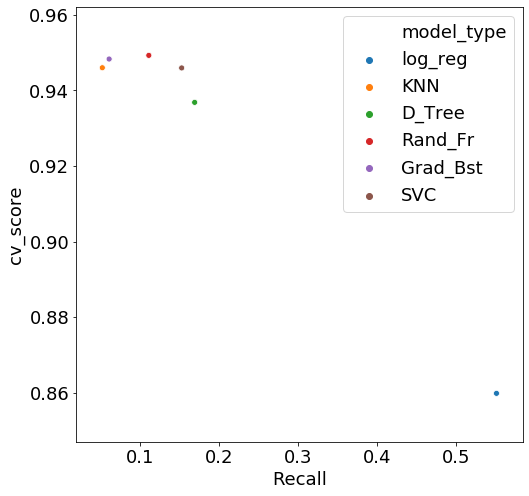

In [24]:
# Visualisation of accuracy vs. recall for these models show a distinct trade-off, the model(s) to
# take forward are the ones which minimize the accuracy recall trade-off

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
sns.scatterplot(model_tracker["recall"], model_tracker["cv_score"], hue= model_tracker["model_type"])

plt.xlabel("Recall")
plt.ylabel("cv_score")
plt.show()

#### Assess Optimal Sampling Technique with Various Models
* To improve the models in terms of identifying the minority class, several under and oversampling methodologies were applied to the training set


In [5]:
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     NearMiss)
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

In [6]:
# create dataframe to track params & scoring
cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [7]:
# creating class called tiny target which will evaluate several different sampling techniques on a user selected model
class tiny_target:
    def __init__(self, X, y, scaler= MaxAbsScaler(), model= LogisticRegression(), sampling_strategy= 0.5, train_size = 0.75, run_all = True, cv_scoring = "recall", stratify = y, cv= 5, tracker = None, name = "model"):
        if tracker is not None:
            self.tracker = tracker
        else:
            cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
            model_tracker = pd.DataFrame(columns= cols)
            self.tracker = model_tracker
            
        self.X = X
        self.y = y
        self.model = model
        self.sampling_strategy = sampling_strategy
        self.train_size = train_size
        self.stratify = stratify
        self.cv = cv
        self.name = name
        self.cv_scoring = cv_scoring
        self.tracker = tracker
    
    def model_runner(self):
        """runs models and appends various scoring metrics (y target focused) to model tracker"""
        self.model.fit(self.X_train_new, self.y_train_new)
        self.scores = cross_val_score(self.model, self.X_train_new, self.y_train_new, cv= self.cv, scoring = self.cv_scoring)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        
        self.model_tracker()
        
    def model_tracker(self):
        self.results = pd.DataFrame({'Model': self.name, 'Method': self.method, 'cv_score': self.scores.mean(), 
                                'training_score': self.training_score,'accuracy': self.class_report["accuracy"],
                                'precision': self.class_report["1.0"]["precision"], 'recall': self.class_report["1.0"]["recall"],
                                'f1-score': self.class_report["1.0"]["f1-score"], 'TP': self.tp, 'FP': self.fp,
                                'TN': self.tn, 'FN': self.fn}, index=[len(model_tracker.index)])
        self.tracker =  pd.concat([self.tracker, self.results])
    
    def run_all(self):
        self.random_under()
        
        self.tomeklinks()
        self.neighbourhoodclean()
        self.nearmiss()
        self.smote_upsample()
        self.random_over()
        self.adasyn()
        return self.tracker
    
    def random_under(self):
        """Randomly undersamples the predictor class. Can lead to loss of information 
        unless the majority class is relatively uniform"""
        
        self.sampler = RandomUnderSampler(sampling_strategy= self.sampling_strategy, random_state= 13)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split( \
            self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Random Under"
        self.model_runner() 
        print("Random undersample run complete")
        return self.tracker
    
    def clustercentroids(self):
        """This method undersamples the majority class by replacing a cluster of majority samples. 
        Clusters of majority class found with K-mean algorithms. Then it keeps the cluster centroids of the 
        N clusters as the new majority samples"""
        self.sampler = ClusterCentroids(sampling_strategy= self.sampling_strategy, random_state= 13)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Cluster Centroids"
        self.model_runner()
        
        print("Cluster centroids run complete")
        return self.tracker
    
    def tomeklinks(self):
        """Finds samples near the borderline of the two classess. Given two instances, a & b seperated by distance
        d(a,b) the pair is called a Tomek link if there is no instance c such that d(a,c) < d(a,b) or d(b,c) < d(a,b)
        Instances within Tomek links are considered noise or borderline and are thus removed"""
        
        self.sampler = TomekLinks()
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Tomek Links"
        self.model_runner()
        
        print("TomekLinks run complete")
        return self.tracker
    
    def neighbourhoodclean(self):
        """ Edited Nearest Neighbor Rule (ENN) to remove any instance whose class label is different from the class
        of at least two of its three nearest neighbors. Neighbourhood cleaning rule uses ENN to remove majority samples
        Finds three nearest neighbors for each training set instance, if majority class and opposite to its neighbours 
        it is removed. If belongs to the target class than the neighbours are removed"""
        
        self.sampler = NeighbourhoodCleaningRule()
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Neighbourhood Clean"
        self.model_runner()
        
        print("Neighbourhood Cleaning run complete")
        return self.tracker
    
    def nearmiss(self):
        """Calculates distances between all instance of majority and minority classes. K instances of the majority
        class with smallest distances to minority are selected and removed"""
        
        self.sampler = NearMiss(sampling_strategy= self.sampling_strategy)
        
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.method = "Near Miss"
        self.model_runner()
       
        print("Near Miss run complete")
        return self.tracker
        
    
    def smote_upsample(self, k_neighbors = 5):
        self.k_neighbors = k_neighbors
        self.sampler = SMOTE(sampling_strategy= self.sampling_strategy, random_state= 13, k_neighbors= self.k_neighbors)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "SMOTE"
        self.model_tracker()
        
        print("SMOTE run complete")
        return self.tracker
    
    def random_over(self):
        self.sampler = RandomOverSampler(sampling_strategy= self.sampling_strategy, random_state= 13)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)
      

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "Random oversample"
        self.model_tracker()
        
        print("Random oversample run complete")
        return self.tracker
        

        
    def adasyn(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors
        self.sampler = ADASYN(sampling_strategy= self.sampling_strategy, random_state= 13, n_neighbors= self.n_neighbors)
        self.X_train, self.X_test, self.y_train , self.y_test = train_test_split(self.X, self.y, train_size=self.train_size, stratify=self.stratify, random_state=13)

        cv = KFold(n_splits=5, shuffle = True)
        self.scores = np.array([])
        for train_fold_index, val_fold_index in cv.split(self.X_train, self.y_train):
         
             # Get the training data
            X_train_fold, y_train_fold = self.X_train.iloc[train_fold_index], self.y_train[train_fold_index]
        # Get the validation data
            X_val_fold, y_val_fold = self.X_train.iloc[val_fold_index], self.y_train[val_fold_index]

        # Upsample only the data in the training section
            X_train_fold_upsample, y_train_fold_upsample = self.sampler.fit_resample(X_train_fold,
                                                                           y_train_fold)
            model_obj = self.model.fit(X_train_fold_upsample, y_train_fold_upsample)
            score = recall_score(y_val_fold, model_obj.predict(X_val_fold))
            self.scores = np.append(self.scores, score)  
        
        self.X_train_new, self.y_train_new = self.sampler.fit_resample(self.X_train, self.y_train)
        self.model.fit(self.X_train_new, self.y_train_new)
        self.training_score = self.model.score(self.X_train_new, self.y_train_new)

        # predict and get classification report & confusion matrix info
        self.predictions = self.model.predict(self.X_test)
        self.class_report = classification_report(self.y_test, self.predictions, output_dict= True)
        self.tn, self.fp, self.fn, self.tp = confusion_matrix(self.y_test, self.predictions).ravel()
        self.method = "ADASYN"
        self.model_tracker()
        
        print("ADASYN run complete")
        return self.tracker
        

#### Prioritising for Recall

In [8]:
# create dataframe to track params & scoring
cols = ["Model", "Method", "cv_score", "training_score", "accuracy", "precision", "recall", "f1-score", "TP", "FP", "TN", "FN"]
model_tracker = pd.DataFrame(columns= cols)

In [9]:
model_tracker

Empty DataFrame
Columns: [Model, Method, cv_score, training_score, accuracy, precision, recall, f1-score, TP, FP, TN, FN]
Index: []

In [10]:
y[10000]

0.0

In [11]:
# fit log reg instance of tiny target
tt = tiny_target(X,y, model= LogisticRegression(solver = "sag", max_iter = 10000), tracker = model_tracker, name = "log_reg")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete
TomekLinks run complete
Neighbourhood Cleaning run complete
Near Miss run complete
SMOTE run complete
Random oversample run complete
ADASYN run complete


In [12]:
# fit KNN instance of tiny target
tt = tiny_target(X,y, model= KNeighborsClassifier(), tracker = model_tracker, name = "KNN")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete
TomekLinks run complete
Neighbourhood Cleaning run complete
Near Miss run complete
SMOTE run complete
Random oversample run complete
ADASYN run complete


In [13]:
# fit decision tree instance of tiny target
tt = tiny_target(X,y, model= DecisionTreeClassifier(min_samples_split= 50), tracker = model_tracker, name = "Dec_Tree")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete
TomekLinks run complete
Neighbourhood Cleaning run complete
Near Miss run complete
SMOTE run complete
Random oversample run complete
ADASYN run complete


In [14]:
# fit random forest instance of tiny target
tt = tiny_target(X,y, model= RandomForestClassifier(n_estimators= 100, n_jobs= 2), tracker = model_tracker, name = "Ran_FR")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete
TomekLinks run complete
Neighbourhood Cleaning run complete
Near Miss run complete
SMOTE run complete
Random oversample run complete
ADASYN run complete


In [15]:
# fit grad boost instance of tiny target
tt = tiny_target(X,y, model= GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=1), tracker = model_tracker, name = "GB")
model_tracker = model_tracker.append(tt.run_all())

Random undersample run complete
TomekLinks run complete
Neighbourhood Cleaning run complete
Near Miss run complete
SMOTE run complete
Random oversample run complete
ADASYN run complete


In [16]:
model_tracker.to_csv("/Users/samholt/GA/DSI12-lessons/projects/Capstone_Project/Capstone_MKII_Model_tracker.csv'")

In [17]:
model_tracker.sort_values(by = "recall", ascending= False)

Model               Method  cv_score  training_score  accuracy  \
49    Ran_FR            Near Miss  0.583594        1.000000    0.7754   
49    Ran_FR            Near Miss  0.583594        1.000000    0.7754   
21  Dec_Tree            Near Miss  0.563167        0.882778    0.7333   
21  Dec_Tree            Near Miss  0.563167        0.882778    0.7333   
21  Dec_Tree            Near Miss  0.563167        0.882778    0.7333   
..       ...                  ...       ...             ...       ...   
0    log_reg  Neighbourhood Clean  0.000000        0.938515    0.9469   
0    log_reg          Tomek Links  0.000000        0.946406    0.9469   
0    log_reg  Neighbourhood Clean  0.000000        0.938515    0.9469   
0    log_reg  Neighbourhood Clean  0.000000        0.938515    0.9469   
0    log_reg          Tomek Links  0.000000        0.946406    0.9469   

    precision    recall  f1-score   TP    FP     TN    FN  
49   0.134611  0.595664  0.219597  632  4063  14876   429  
49   0.134611  0.595664  0.219597  632  4063  14876   429  
21   0.112883  0.587182  0.189362  623  4896  14043   438  
21   0.112883  0.587182  0.189362  623  4896  14043   438  
21   0.112883  0.587182  0.189362  623  4896  14043   438  
..        ...       ...       ...  ...   ...    ...   ...  
0    0.000000  0.000000  0.000000    0     1  18938  1061  
0    0.000000  0.000000  0.000000    0     1  18938  1061  
0    0.000000  0.000000  0.000000    0     1  18938  1061  
0    0.000000  0.000000  0.000000    0     1  18938  1061  
0    0.000000  0.000000  0.000000    0     1  18938  1061  

[217 rows x 12 columns]

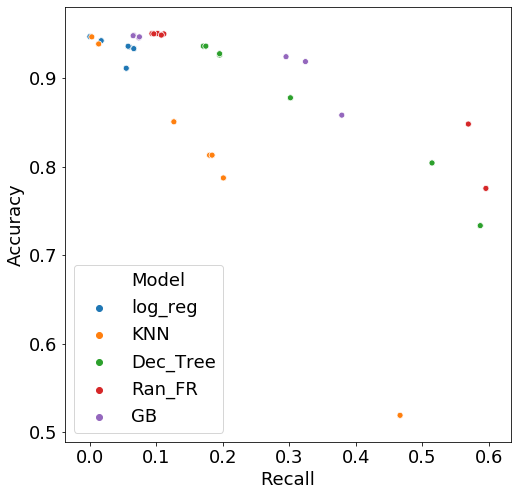

In [18]:
# Visualisation of accuracy vs. recall for these models show a distinct trade-off, the model(s) to
# take forward are the ones which minimize the accuracy recall trade-off

plt.figure(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})
sns.scatterplot(model_tracker["recall"], model_tracker["accuracy"], hue= model_tracker["Model"])

plt.xlabel("Recall")
plt.ylabel("Accuracy")
plt.show()

In [19]:
#select models which maximize both accuracy & recall, defined as 80% accuracy and 50% recall
model_tracker[(model_tracker["recall"] > 0.49) & (model_tracker["accuracy"] > 0.79)][["Model", "Method", "accuracy", "recall"]]

Model        Method  accuracy    recall
21  Dec_Tree  Random Under   0.80415  0.514609
21  Dec_Tree  Random Under   0.80415  0.514609
49    Ran_FR  Random Under   0.84810  0.569274
21  Dec_Tree  Random Under   0.80415  0.514609
21  Dec_Tree  Random Under   0.80415  0.514609
49    Ran_FR  Random Under   0.84810  0.569274

In [20]:
model_tracker

Model               Method  cv_score  training_score  accuracy  \
0    log_reg         Random Under  0.019487        0.670124   0.94225   
0    log_reg          Tomek Links  0.000000        0.946406   0.94690   
0    log_reg  Neighbourhood Clean  0.000000        0.938515   0.94690   
0    log_reg            Near Miss  0.065057        0.680180   0.91115   
0    log_reg                SMOTE  0.061542        0.678623   0.93530   
..       ...                  ...       ...             ...       ...   
105       GB  Neighbourhood Clean  0.062541        0.943248   0.94790   
105       GB            Near Miss  0.379013        0.794155   0.85815   
105       GB                SMOTE  0.075489        0.925047   0.94550   
105       GB    Random oversample  0.293854        0.759724   0.92420   
105       GB               ADASYN  0.070698        0.924757   0.94660   

     precision    recall  f1-score   TP    FP     TN    FN  
0     0.138462  0.016965  0.030227   18   112  18827  1043  
0     0.000000  0.000000  0.000000    0     1  18938  1061  
0     0.000000  0.000000  0.000000    0     1  18938  1061  
0     0.069712  0.054665  0.061278   58   774  18165  1003  
0     0.175487  0.059378  0.088732   63   296  18643   998  
..         ...       ...       ...  ...   ...    ...   ...  
105   0.579832  0.065033  0.116949   69    50  18889   992  
105   0.155814  0.378888  0.220818  402  2178  16761   659  
105   0.421622  0.073516  0.125201   78   107  18832   983  
105   0.289547  0.295005  0.292250  313   768  18171   748  
105   0.478788  0.074458  0.128874   79    86  18853   982  

[217 rows x 12 columns]

#### Gridsearch & Optimize Best Model
* Due to time constraints one logistic regression model was taken forward for analysis & gridsearch on the full dataset
* Gridsearching based on our best model, logistic regression combined with random undersampling
* Random undersampling loses a lot of data so we are using the model on the full sparse DF

In [21]:
# fit sampler

sampler = RandomUnderSampler(sampling_strategy= 0.5, random_state= 13)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, stratify = y, random_state = 13)

X_train_new, y_train_new = sampler.fit_resample(X_train, y_train)

In [22]:
model = RandomForestClassifier(n_jobs= 2)

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [10, 100, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [10, 100, 10]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

model_GS = GridSearchCV(estimator=model,
                param_grid=params,
                cv=5,
                scoring='recall',
                return_train_score=True, verbose= 2)

In [ ]:
# fit model and assess classification report
model_GS.fit(X_train_new,y_train_new)
print("Baseline testing score was: {}".format(str(baseline)))
print("Logistic regression best mean cross val score was: {}".format(str(cross_val_score(model_GS, X_train_new, y_train_new, cv=5).mean())))
print("Logistic regression best training score was : {}".format(str(model_GS.score(X_train_new, y_train_new))))
predictions = model_GS.predict(X_test)


Fitting 5 folds for each of 43200 candidates, totalling 216000 fits
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s remaining:    0.0s


[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673, total=   6.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673, total=   6.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673, total=   6.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   6.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942, total=   7.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=407 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1059 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443, total=   5.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692, total=   6.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1692 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   6.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827, total=   6.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942, total=   7.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942, total=   7.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328, total=   5.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328, total=   4.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1462 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   6.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   6.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980, total=   7.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980, total=   7.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980, total=   7.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980, total=   7.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=195 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=311, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=311, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=445, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=560, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=579 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=694, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=829 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=944, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=944, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=10

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1193, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1213, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=12

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1328, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1328, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1328, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1347, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=13

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=14

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1577, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1577, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=15

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1712, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=17

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1827, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1846, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=18

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1961, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1961, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1961, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1980, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=19

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   5.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   5.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=195, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=848, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1501, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1501 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1635 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   7.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=234, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=234 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=368 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=886, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=886 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1021 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1270, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1270 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   5.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   5.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   5.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   5.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1654 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769, total=   6.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   6.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   6.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1904 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1904, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1904 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   5.1s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.6s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   5.5s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673, total=   6.0s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   6.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   6.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   6.3s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808, total=   6.4s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.8s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   6.9s
[CV] bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=445, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=445, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=445 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=579, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=579 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=714 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1097, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1097 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1347, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1347, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1481 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1731 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1731, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1731 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1980, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1980, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=195, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=714, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=714, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=848, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1366, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1366, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1501, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1501 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1635 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=234, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=234 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=368 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=752, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=752, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=752 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=886, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=886 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1021 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1270, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1270 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1520, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1520, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1520 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1654 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1904 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1904, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1904 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=234, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=234 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=234, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=234 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=368 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=464, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=618, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=618 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=848 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=867 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1002 
[CV

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1097, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=11

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1232 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=12

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=13

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1481 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1501, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1501, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=15

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=16

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1731, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=17

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1865 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1865 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=18

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=20

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   0.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  b

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  boot

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   1.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1769, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   3.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=503, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637, total=   1.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   1.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   1.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   2.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155, total=   2.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   2.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1405, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   3.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   3.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   4.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   4.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   0.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   0.9s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   1.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   1.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   2.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.7s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   2.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.0s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.2s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   3.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   3.5s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   3.6s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   3.8s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   4.1s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootst

[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.4s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   4.3s
[CV] bootstrap=True, max_depth=10, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   7.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=   8.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   9.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   9.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   8.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  10.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  10.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  10.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=  10.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  11.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  11.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  10.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  11.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=330, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=464, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=464, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=752 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=982, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV] 

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   6.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136, total=   6.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1366, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1366, total=   7.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   7.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   7.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   8.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1520 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1616, total=   9.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   9.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   8.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   9.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769, total=   9.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=2000, total=  10.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=2000, total=  10.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstra

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1021 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   6.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   7.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   7.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   7.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   7.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   7.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   7.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   7.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   8.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   8.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   9.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1673 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   9.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=  12.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=  10.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=  11.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=138, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=138, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=138 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=272, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=272 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=407 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=790, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=790, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=790 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=925, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=925 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1059 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1309, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1309 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1558, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1558, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1558 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1692 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1942 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1942, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1942 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=138 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=272, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=272, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=272 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=407 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=503, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=522 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=637, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=637, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=637, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=656 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=771 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=886, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=886 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=886, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=906 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1021, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=10

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=11

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1270, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1270, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1270, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1289, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=12

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=14

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1520, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1520, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=15

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=16

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1769, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1788, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=17

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1904, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1904 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1904, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1904 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1904, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=19

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=119 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=234, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=253 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=368, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=368 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=368, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=387 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=503, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=503, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=503 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=503, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=522 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=637, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=656 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=771 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=886, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=906 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1021, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1021 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1021, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1040 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1155, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1174 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1270, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1289 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1405, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1424 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1539 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1654, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1673 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1788, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1808 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1904, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1923 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   7.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   6.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289, total=   7.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   7.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   7.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   7.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   8.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   8.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   9.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   9.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942, total=  10.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=  10.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=  10.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=  10.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=311, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=445 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675, total=   3.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=963, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1097 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   6.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   6.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   7.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   7.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   7.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1347, total=   7.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   7.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=   8.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=   8.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=   8.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=   8.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   9.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=   9.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1731 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   9.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=   9.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  10.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  10.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  10.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1980, total=  10.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   6.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   6.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   6.9s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=   6.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   7.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366, total=   7.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   8.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1501 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   8.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   9.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   9.6s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   9.7s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   9.4s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  10.3s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  10.0s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=  10.1s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=  10.2s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  10.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  10.8s
[CV] bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  10.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1769, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=119, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=138 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=272 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=387 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=503, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=522 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=637, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=656 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=771, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=790 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=925 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1040 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1155, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1174 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1289, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1309 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1424 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1539, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1558 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1673 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1808 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1923, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1942 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=407 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1059 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1193 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   4.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1328 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=   4.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1712 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1846 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1980 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=311 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=445, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=445 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=579 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=963 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1097 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1347, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1347 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1731 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1980, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1980 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=176, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=195 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=291, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=311 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=445, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=445 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=560 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=675, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=675 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=675, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=694, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=694, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=694 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=829 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=925, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=944 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1059, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1059 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1059, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1059 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1059, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1078, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=10

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1193, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=11

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1309, total=   2.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1309 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1309, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=13

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1443, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=14

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1558, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=15

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1692, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1692, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1692 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1692, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1712, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=17

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=18

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1942, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1942 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1942, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=1961, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=100, n_estimators=19

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=157, total=   0.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291, total=   0.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=291 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=407, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=426 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=541, total=   1.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=541 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=541, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=560 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=675, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=675, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=675 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=675, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=694 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=810, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=944 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1059, total=   1.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1078 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1193, total=   2.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1193, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1193 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1193, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328, total=   2.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1328 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1443, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1443, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1462 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1577, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1692, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1712 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1827, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846, total=   2.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=100, min_samples_split=10, n_estimators=1961 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=157, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=291 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=810, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   2.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=944 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   3.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1462, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1596 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=   4.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   6.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   0.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=215 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=330 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=349 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=464, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=464, total=   1.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=464 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=598, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=733 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=867 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1002 
[CV]  b

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1232, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1251 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1366, total=   4.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1366, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1385, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1501 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1635, total=   4.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1635 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   5.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1865, total=   5.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884, total=   5.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=1884 
[CV]

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=2000, total=   5.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=100, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=100 
[CV]  boot

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=234 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   1.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618, total=   2.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752, total=   2.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=752 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=886 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270, total=   3.9s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=   4.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405, total=   4.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1405 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=   4.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1539 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=   5.0s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1769, total=   5.3s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788, total=   5.2s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1788 
[CV]  bootst

[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1904, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   5.6s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923, total=   5.7s
[CV] bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=10, n_estimators=1923 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=119, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=138 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=253, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=272 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   3.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387, total=   3.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=387 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=503, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   4.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=522 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637, total=   4.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=637, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=656 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771, total=   7.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=771, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=790 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   6.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   7.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   6.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=906, total=   6.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=925 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   7.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   7.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   7.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040, total=   7.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1040 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1155, total=   8.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   8.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   8.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174, total=   8.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1174 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289, total=   9.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1289, total=   9.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=  10.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309, total=   9.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1309 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424, total=  10.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424, total=  10.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1424, total=  10.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443, total=  10.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1443 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=  11.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=  10.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=  13.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1558, total=  12.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1577 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=  11.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=  12.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=  13.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692, total=  14.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1692 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1808, total=  12.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=  13.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=  12.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827, total=  13.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1827 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942, total=  14.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1942, total=  14.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=  15.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961, total=  13.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1961 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=157, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176, total=   1.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=176 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=291, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=311 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   3.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   3.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=426 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=541, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   4.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560, total=   4.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=560 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675, total=   4.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=675, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=694 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810, total=   5.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810, total=   5.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=810, total=   5.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=829 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   6.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   6.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   6.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=944, total=   6.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=963 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   7.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   8.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   7.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078, total=   7.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1078 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193, total=   8.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1193, total=   8.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   8.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213, total=   8.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1213 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   9.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   9.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   9.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1328, total=   9.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1347 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1443, total=  11.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=  10.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=  10.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462, total=  10.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1462 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=  10.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=  10.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1577, total=  10.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596, total=  10.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1596 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=  12.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=  11.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=  11.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712, total=  11.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1712 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827, total=  12.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1827, total=  12.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=  12.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846, total=  12.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1846 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  13.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  13.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  13.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1961, total=  13.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=100, n_estimators=1980 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176, total=   1.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=176 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=291, total=   2.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311, total=   2.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=311 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=426, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=445 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   4.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=560, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=579 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=694, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   6.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=829 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=944, total=   8.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   8.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   7.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963, total=   8.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=963 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   8.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1078, total=   7.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   7.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097, total=   8.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1097 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=  11.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=  10.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1213, total=   8.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232, total=  11.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1232 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=  12.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=  11.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=  10.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1347, total=  11.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1366 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=  12.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=  12.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=  10.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481, total=  11.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1481 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1596, total=  11.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=  12.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=  11.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616, total=  11.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1616 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=  13.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1731, total=  13.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=  14.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750, total=  13.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1750 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  13.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  13.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1865, total=  13.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884, total=  13.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1884 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  15.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  13.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  14.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=2000, total=  13.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=100 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   0.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=483 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=618, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=618 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=752 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   3.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV] 

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1136, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1136 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1385, total=   4.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1385 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1520 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   4.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635, total=   4.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1769, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1769 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=100, total=   0.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=100 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=234 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   1.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=349 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464, total=   1.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=483, total=   1.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=483 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=598 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=733 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=867 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=963, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   3.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=982 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1097, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1097 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1097 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=11

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   3.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   3.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1232, total=   3.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=12

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1347 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1347, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   4.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=13

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1481, total=   4.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=15

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1596, total=   4.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1616, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=16

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1731, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1731 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1731 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1731, total=   5.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=17

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   5.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1865, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=18

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1980, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1980 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=1980, total=   5.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=100, n_estimators=20

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=195, total=   0.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215, total=   1.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=215 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=330, total=   1.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=349 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464, total=   1.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=464 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=579, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598, total=   2.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=598 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=714, total=   2.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733, total=   2.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=733 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=848, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=867 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=982, total=   3.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1002 
[CV]  boots

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1097, total=   3.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1117 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   4.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1232, total=   3.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251, total=   3.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1251 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366, total=   4.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1366 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1481, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501, total=   4.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1501 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1616, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1635 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1731, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750, total=   5.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1750 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1865, total=   5.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884, total=   5.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=1884 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   6.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000, total=   6.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=100, min_samples_split=10, n_estimators=2000 
[CV]

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=195, total=   1.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   2.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   2.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215, total=   2.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=215 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=330, total=   2.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=330 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=330, total=   3.4s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349, total=   2.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=349 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=464 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=464, total=   3.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483, total=   3.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=483 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   4.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   4.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   5.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=598, total=   4.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=618 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   6.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   6.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   6.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733, total=   5.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=733 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=848, total=   6.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   6.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   6.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867, total=   6.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=867 
[CV]  bootstrap=True

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=982, total=   7.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=982 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=982, total=   7.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   7.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002, total=   8.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1002 
[CV]  bootstrap

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   7.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   8.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1117 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1117, total=   9.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136, total=   8.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1136 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   8.9s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   8.7s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   8.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1251, total=   9.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1270 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=  11.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=  10.6s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=  10.2s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385, total=  11.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1385 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1501, total=  11.0s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=  11.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=  10.8s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520, total=  11.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1520 
[CV]  bootst

[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1635, total=  11.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1635 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1635, total=  12.3s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=  12.1s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654, total=  14.5s
[CV] bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=10, min_samples_split=10, n_estimators=1654 
[CV]  bootst

In [ ]:
print(classification_report(y_test, predictions))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

plot_confusion_matrix(model_GS,X_test, y_test, ax = ax, values_format="")
plt.ylim()
plt.show()

In [ ]:
# collect the model coefficients in a dataframe
df_coef = pd.DataFrame(model_GS.best_estimator_.coef_, columns= unique_subs[:-1],
                       index=['coefficients'])
# calculate the absolute values of the coefficients
df_coef = df_coef.T
df_coef['coef_abs'] = df_coef.coefficients.abs()
df_coef.sort_values(by = "coef_abs", ascending = False).head(5)

In [ ]:
f, ax = plt.subplots(figsize = (8, 13))
df_coef['coef_abs'].sort_values(ascending = False).head(15).plot(kind='barh');
plt.show()

## Summary & Next Steps
* Overall the evaluated models offer potential for identifying mental health risk in internet forum users
* In particular, the greatest potential use case is likely to be identifying users who may not currently be aware of, and post to, support forums but who could benefit from their supports & thus promotion on over popular subreddits
* The high recall at the expense at accuracy is too much in some cases, though a high number of false positives is not as much of an issue for a risk analyses, and indeed may reflect current sufferers of mental health issues who simply do not post to reddit about their issues
* Their are some potential risks & limitations for this research:
    * The demographic used in the sample is likely to be younger & focused on North America & Europe 
    * The majority of users on any website are ‘lurkers’ and do not post, this research assumes that they are represented & do not differ significantly in personality etc. than those who do post
    * Key assumption is that posting on mental health forums is indicative of mental health risk 
* Next steps would include:
    * Grid Searching & fine tuning remaining models
    * Expanding data set to incorporate additional years for greater breadth of sample
    * Network analysis to flesh out those subreddits most closely related to mental health 
